## Discover media discourse in Spanish flu coverage with diachronic bi-gram clouds and topic modeling

Created by Sarah Oberbichler [![ORCID](https://info.orcid.org/wp-content/uploads/2019/11/orcid_16x16.png)](https://orcid.org/0000-0002-1031-2759)

The Spanish flu of 1918/19 is known as a influenza pandemic that spread in three waves over Europe, Asia and North America and then over the southern hemisphere in a period of around 13 months, probably infecting a third of the world's population (around 500 million people) and causing around 50 million deaths. Since all influenza A epidemics since then have been identified as descendants of the 1918 virus, the Spanish flu is often called the "mother of all pandemics." 

Media coverage was hampered by the events of the war. Newspaper reports continued to be censored, especially with regard to the first wave in late spring and early summer 1918, which was only recognized at a late stage, but also the second, extremely fatal wave between September and November of the same year. The third, far less violent wave was then little reported, despite the end of the war. In Europe, the epidemic was always analyzed in the context of the war, meaning that it was interpreted as a "footnote of World War I" (L. Spinney, Pale Rider, 2017). In fact, more people died here as a result of the war, or death was still seen by many as a consequence of the war.

In this notebook, we examine news coverage of the Spanish flu in French, German, or Finnish corpora. The notebook computes diachronic n-grams and topic models that allow us to take a first look at the collection and find possible *discourse markers* for further, qualitative analysis.

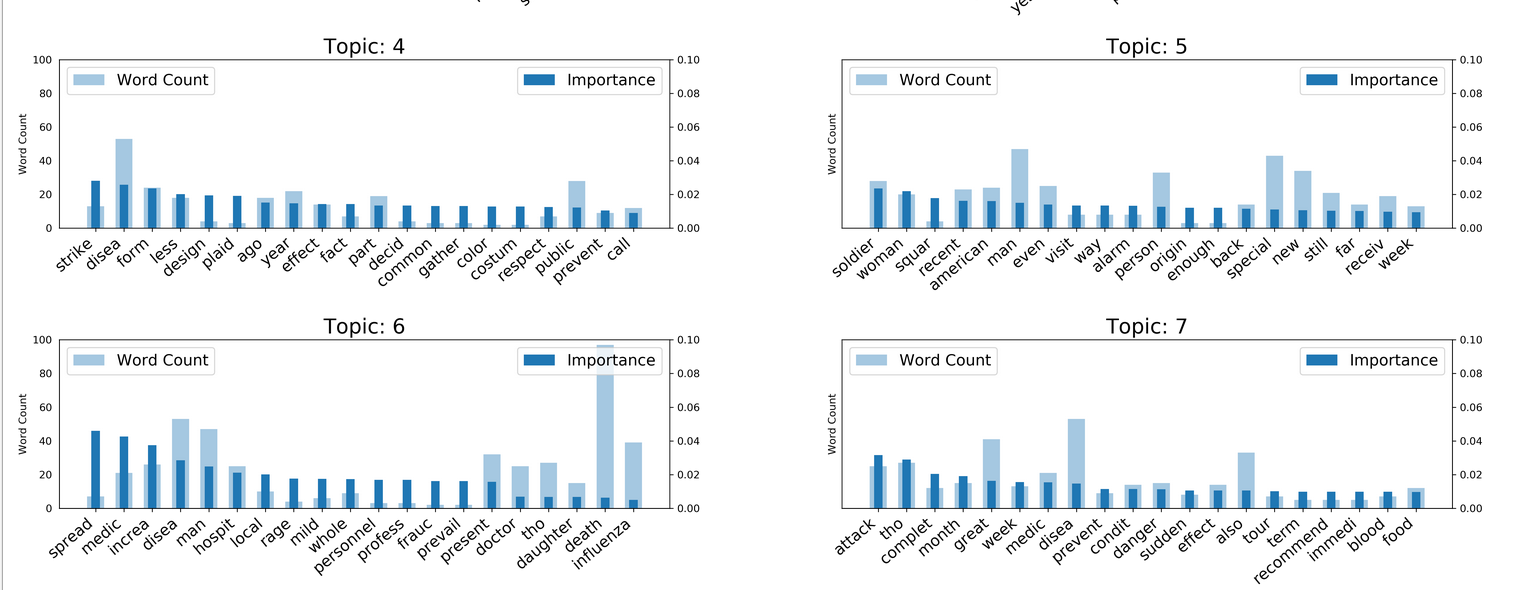

## Step by step...

* [Run code](#1-bullet)
* [Import your newspaper collection](#2-bullet)
* [Create a frequency graph using the publication date and the newspaper title](#3-bullet)
* [Clean, tokenize and stem (pre-processing)](#4-bullet)
* [Add part of speach (POS) tags, form n-grams and lemmatize](#5-bullet)
* [How did the discourse on the Spanish Flu change over the months?](#6-bullet)
* [What tpics can you find the in the newspaper coverage on the Spanish Flu?](7#-bullet)
* [Change or adapt parameters](#8-bullet)
* [Browse original texts](#9-bullet)


## Run code <a class="anchor" id="1-bullet"></a>

In order to run code in *Jupyter Notebooks*, you need to click on **Run** in the tool bar, which is above the main notebooks area or use the command mode shortcut "shift-enter". When you "run" a cell, an asterisk appears in the parentheses next to the cell. This cell was successfully executed when a digit appears in the parentheses. 
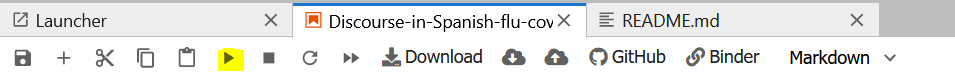

In [ ]:
#language processing imports
import gensim, spacy, logging, warnings
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from nltk.stem.porter import PorterStemmer
import gensim.corpora as corpora
import time
from gensim.models import LdaModel
nltk.download('punkt')
nltk.download('stopwords')

#For the text overview
from nltk import FreqDist

#Word Cloud and Visualization

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

## Import your newspaper collection <a class="anchor" id="2-bullet"></a>

Now you can add your exported dataset to the file in the entry page. You can directly import the saved dataset from your downloads. Copy the exported dataset into "Data". Then, copy the title of the dataset after **'Date/**
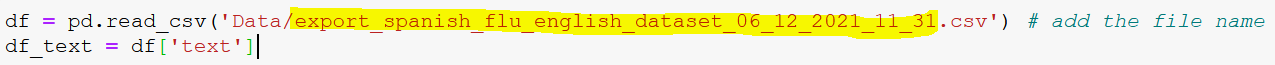



In [ ]:
df = pd.read_csv('Data/.csv') # add the file name 
df_text = df['text']

## Create a frequency graph using the publication date and the newspaper title  <a class="anchor" id="3-bullet"></a>
    
Here you can find out which newspapers reported about the Spanish flu and how often. 

In [ ]:
fig = plt.figure()
df['date']=pd.to_datetime(df['date']).dt.strftime('%Y')


fig = df.groupby(['date','newspaper_id']).size().unstack().plot(kind='bar',stacked=True)
plt.savefig('bar.png', dpi = 300)


## Clean, tokenize and stem (pre-processing) <a class="anchor" id="4-bullet"></a>

Before you can start training the bi-gram and tri-gram models, you will need to pre-process your texts. The following functions remove punctuation, lowercase the text, remove stop words, and stem the text.

To successfully remove stop words, it is important to specify the language of your dataset. 



In [ ]:
#Functions to clean, tokenize, and stem the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')#change the language here

stop_words.extend(['last', 'week', 'case', 'number', 'cases', 'yesterday', 'week', 'ago']) #add additional words here
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

df['tokenized'] = df['text'].apply(apply_all) 

## Add part of speach (POS) tags, form n-grams and lemmatize <a class="anchor" id="4-bullet"></a>

A POS tag (or part-of-speech tag) is a special label assigned to each token (word) in a dataset to indicate the part of speech. In this notebook we are using the tags *noun*, *adjective*, *adverb* and *verb*. You can use the tags to narrow down your dataset to specific part-of-speeches, for example, it is possible to see the most used nouns or verbs, depending on what makes sense for the type of dataset. 
The code in the cell below will also form n-grams, and lemmatize the tokenized words. Lemmatization reduces inflected words in order to be able to group them.

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'ADV']): # 'VERB'
    """Form Bigrams, Trigrams and Lemmatization"""
    texts_out = []
    
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])#disable functions here
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])  
    return texts_out

data_ready1 = process_words(df['tokenized'])


## How did the discourse on the Spanish flu change over the months? <a class="anchor" id="6-bullet"></a>

Here you can create diachronic n-gram clouds for specific years or time frames.

#### Run the cell while you read the explanations on n-grams. It will take one or two minutes to load. 

N-grams are contiguous sequences of n items from a given text or speech sample. This means that words are not considered as individual units, but in relation to each other. For scholars in the humanities, n-grams can be helpful to get an overview of their collection or to identify discourse markers (discourse = a group of related texts belonging to a common system of formation). N-grams can never be a research result per se - which is true for any output of NLP methods - but they can help to find important patterns in a particular collection.

If n-grams are used to identify discourse markers, it can be useful to create diachronic n-grams to explore the change of textual patterns. This notebook therefore shows how diachronic n-grams can be built and visualized.

In [ ]:
df['year']=(pd.to_datetime(df['date']).dt.strftime('%Y')) # year = %Y, month = %m
df['year'] = df['year'].astype(int)

_1918 = (df['year'] > int('1917')) & (df['year'] <= int('1918'))
_1919 = (df['year'] > int('1918')) & (df['year'] <= int('1919'))
_1920 = (df['year'] > int('1919')) & (df['year'] <= int('1920'))


#This will be used for the title of the clouds
time_frame = ['1918', '1919', '1920',]

#Here you create a list containing the information on your selected time-frames
selection = []
selection.append(_1918)
selection.append(_1919)
selection.append(_1920)


#Get your bigrams for every selected time frame
selection[0] = df.loc[_1918]['tokenized']
selection[1] = df.loc[_1919]['tokenized']
selection[2] = df.loc[_1920]['tokenized']


#Create the diachronic N-gram clouds
i = -1
while i < len(selection) -1:
    i = i +1 
    data_ready3 = process_words(selection[i])  # processed Text Data!
    bigrams_list = list(nltk.bigrams(data_ready3))
    dictionary = [' '.join([str(tup) for tup in bigrams_list])]
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq)
    WC_height = 1000
    WC_width = 1500
    WC_max_words = 500
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
    wordCloud.generate_from_frequencies(words_dict)
    plt.figure(figsize=(15, 8))
    plt.plot
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title(time_frame[i], size= 'x-large')
    plt.axis("off")
    plt.savefig('cloud.png', dpi = 300)
print()

## What kind of topics can you find the in the newspaper coverage on the Spanish flu? <a class="anchor" id="7-bullet"></a>

Topic modeling is a probability-based method for exploring larger text collections. The method generates statistical models (topics) for mapping frequent common occurrences of words. All topic models are based on the same basic assumption:

    1. each document consists of a mixture of topics, and
    2. each topic consists of a collection of words.
    
 Topic models can help to explore a larger collection and find entry points for further investigation. 

In [ ]:
def train_lda(data):
    num_topics = 10
    
    chunksize = 300
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   chunksize=chunksize, minimum_probability=0.0, passes=20, iterations=200, per_word_topics=True, update_every=1)
    return dictionary,corpus,lda

dictionary,corpus,lda = train_lda(data_ready1)

#### Now visualize the results of the topic modeling

Run the code and check out the results. Do they make sense in our eyes? Can you interpret some of the topics? Use the cell **Browse original texts** if you want to check out some of the words in their original context. Add your search term where you see 'flu' at the moment. You must search for the word in its original form and keep capitalization in mind.  

In [ ]:
import matplotlib.colors as mcolors
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
topics = lda.show_topics(formatted=False, num_words=20)
data_flat = [w for w_list in data_ready1 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(20,20), sharey=True, dpi=300)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], width=0.6, alpha=0.4, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], width=0.3, label='Importance')
    ax.set_ylabel('Word Count')
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 100)
    ax.set_title('Topic: ' + str(i), fontsize=20)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=40, fontsize=15, horizontalalignment= 'right')
    ax.legend(loc='upper left', fontsize=15); ax_twin.legend(loc='upper right', fontsize=15)

fig.tight_layout(w_pad=12)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.08)    
plt.show()

## Change or adapt parameters: <a class="anchor" id="8-bullet"></a>

1. Remove adjectives from your dataset and see how this changes your results
2. Disable lemmatization while pre-processing your dataset 
3. Train unigrams instad of bi-grams by changing the numbers to 1 in the following line: vectorizer = CountVectorizer(ngram_range=(2, 2))
4. Change the chunksize (number of documents to be used in each training) from 200 to 50 while training your topic modeling algorithm and see how this changes TM results. 

## Browse original texts <a class="anchor" id="-9-bullet"></a>

Here you can browse through the original text. To refine the search, you can reduce the search to those texts that contain a specific word. 

In [ ]:
pd.set_option('display.max_colwidth', -1)


lines_ = ['unit']
for line in df_text:
    if 'children' in line: #insert here the word you are looking for
        lines_.append(line)
    
lines_ = pd.DataFrame(lines_, columns =['text'])
df_select = pd.DataFrame(lines_['text'])
df_select[0:10]    
